In [1]:
from fastai2.basics import *
from fastai2.vision.all import *

import kornia
from mish_cuda import MishCuda

from tqdm.notebook import tqdm

PATH = Path('../..').resolve()

%matplotlib inline

seed = 12345

In [2]:
# reproducability flags
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
def root_mean_squared_error(preds, targs):  return torch.sqrt(F.mse_loss(preds.reshape(-1, 1), targs.reshape(-1, 1)))
def slope(p, y): return ((y-y.mean())*(p-p.mean())).sum()/((y-y.mean())**2).sum()

image_stats = [tensor([-0.0169, -0.0105, -0.0004]), tensor([0.9912, 0.9968, 1.0224])]

item_tfms = []
batch_tfms = aug_transforms(max_zoom=1., flip_vert=True, max_lighting=0., max_warp=0.)+[Normalize.from_stats(*image_stats)]

# Get data

In [19]:
df = pd.read_csv(f'{PATH}/data/a40-SDSS_gas-frac.csv', usecols=(1,2), dtype={'AGCNr': str, 'logfgas': float})

df.head()

,AGCNr,logfgas
0,331061,-0.447361
1,101866,-1.089920
2,101869,-0.350810
3,331082,0.104468
4,101873,-0.153950


In [20]:
dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), RegressionBlock),              # black & white
    get_x=ColReader(['AGCNr'], pref=f'{PATH}/images-OC/', suff='.jpg'),
    get_y=Pipeline([ColReader(['logfgas'], label_delim=None)]),
    splitter=RandomSplitter(0.2, seed=seed),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

dls = ImageDataLoaders.from_dblock(dblock, df, path=PATH, bs=64)

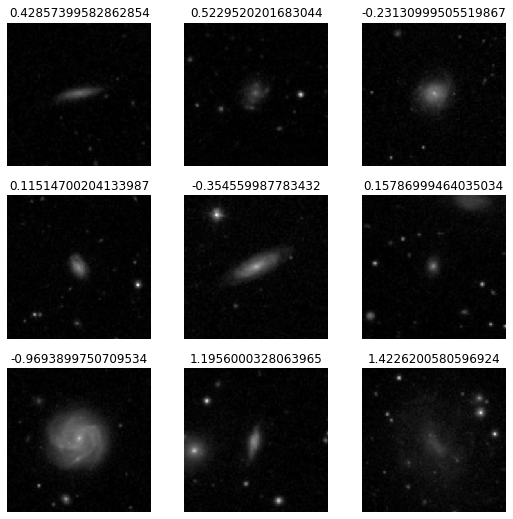

In [21]:
dls.show_batch()

In [22]:
model = xresnet34(sa=True, act_cls=MishCuda, n_out=1)
learn = Learner(dls, model, loss_func=root_mean_squared_error, opt_func=ranger)

SuggestedLRs(lr_min=0.004786301031708717, lr_steep=6.309573450380412e-07)

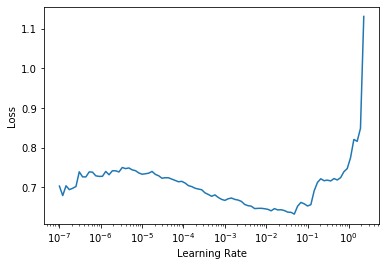

In [8]:
learn.lr_find()

Requires a lower learning rate, it seems.

In [9]:
learn.fit_one_cycle(40, 3e-3)

epoch,train_loss,valid_loss,time
0,0.512166,0.463146,00:34
1,0.432906,0.413741,00:31
2,0.408664,0.370103,00:31
3,0.397649,0.431397,00:31
4,0.400179,0.449647,00:31
5,0.399404,0.413000,00:31
6,0.393041,0.410164,00:31
7,0.385878,0.393393,00:31
8,0.376225,0.348419,00:31
9,0.373394,0.547044,00:31


In [23]:
# learn.save('fastai2-xresnet34-a40A_BW-1')
learn = learn.load('fastai2-xresnet34-a40A_BW-1')

In [11]:
preds, trues = learn.tta()
preds, trues = to_np(preds).flatten(), to_np(trues).flatten()

Text(0, 0.5, '$\\mathcal{M}_{\\rm pred}$')

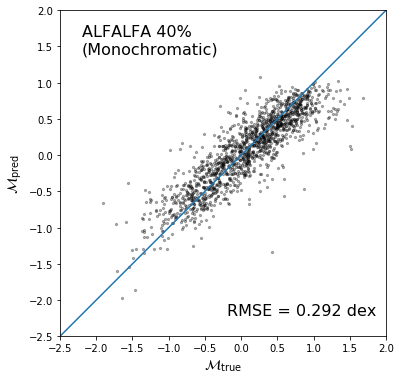

In [12]:
plt.figure(figsize=(6, 6))

plt.scatter(trues, preds, c='k', s=5, alpha=0.3)

plt.plot([-3, 3], [-3, 3])
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.2, 1.4, 'ALFALFA 40%\n(Monochromatic)', fontsize=16)
plt.text(-0.2, -2.2, f'RMSE = {((preds - trues)**2).mean()**0.5:.3f} dex', fontsize=16)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=14)



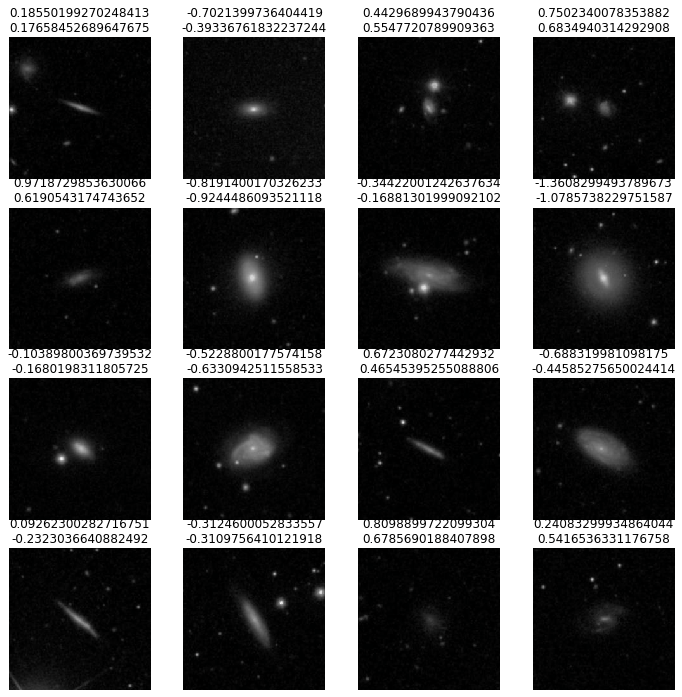

In [14]:
learn.show_results(max_n=16, ncols=4, nrows=4)

# Train (smaller) model on combined ALFALFA + xGASS

In [24]:
df = pd.read_csv(f"{PATH}/data/combined.csv")

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), RegressionBlock),              
    get_x=ColReader(['id'], pref=f'{PATH}/images-combined/', suff='.jpg'),
    get_y=Pipeline([ColReader(['logfgas'], label_delim=None)]),
    splitter=RandomSplitter(0.2, seed=seed),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

dls = ImageDataLoaders.from_dblock(dblock, df, path=PATH, bs=64)

In [25]:
model = xresnet34(sa=True, act_cls=MishCuda, n_out=1)
learn = Learner(dls, model, loss_func=root_mean_squared_error, opt_func=ranger)

SuggestedLRs(lr_min=0.02089296132326126, lr_steep=9.12010818865383e-07)

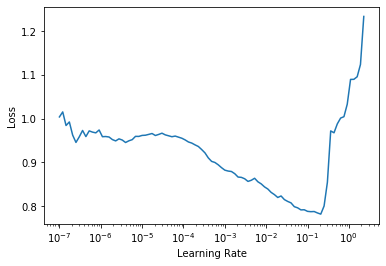

In [26]:
learn.lr_find()

In [27]:
learn.fit_one_cycle(40, 5e-3)

epoch,train_loss,valid_loss,time
0,0.625814,0.569932,00:35
1,0.501672,0.494213,00:35
2,0.466012,0.450830,00:35
3,0.458067,0.467220,00:35
4,0.463388,0.431500,00:35
5,0.446601,0.450316,00:35
6,0.446612,0.446086,00:35
7,0.443034,0.420828,00:35
8,0.436408,0.432358,00:35
9,0.431886,0.411411,00:35


Interesting -- it is not trivially easy to combine xGASS and ALFALFA galaxies using monochromatic imaging. They span a larger range in HI/stellar mass ratio, and this requires color information to ensure high accuracy.